## torch basics

PyTorch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [ ]:
a = torch.ones(3,3)
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [ ]:
b = torch.arange(9).float().view(3,3)
b

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [ ]:
(a+b)**2

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [ ]:
b[:,0]

tensor([0., 3., 6.])

In [ ]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])



If you need more intro: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

So what's the big deal about pytorch?

**autograd = automatic differentiation** which allows to compute derivatives of a computation sequence (graph) automatically. More about this later.

# 3 Intermezzo: optimization with SGD - linear regression example


Here are the core components of a basic deep learning classifier/regression setup:
* a neural network $\hat{y}=f(x, \theta)$, which takes an input $x$ and parameters $\theta$, and outputs a prediction of $y$.
* a loss function $\mathcal{L}(\theta) = \mathbb{E}_{x,y \sim p_d} \ell(f(x, \theta), y) \approx \sum_{x_i,y_i \sim mb} \ell(f(x_i, \theta), y_i)$.
* optimizing $\theta$ to reduce the loss, by making small updates to $\theta$ in the direction of $-\nabla_\theta \mathcal{L}(\theta)$.

pytorch is designed around these core components:
* The way to define a neural network is with `torch.nn.Module`, see how we defined the Discriminator and Generator above.
    - a `Module` defines (1) its weights and (2) defines the operations done with them.
    - initializing a module initializes the weights at random
* $\theta$ stands for all our neural network weights (everything you get from `.parameters()`)
* In the optimization loop you will evaluate a "minibatch" of samples (in our case 64) to compute the neural network output, and the loss measuring how far away those predictions are from the truth.
* To compute the gradient $\nabla_\theta \mathcal{L}(\theta)$, you call `.backward()` on the loss. This is where the magic happens: the gradient wrt all weights in the neural network is computed. They appear in a new Tensor `p.grad` for each `p in net.parameters()`
    - under the hood, this happens by keeping track of the computational graph, and reversing the computation order to "backpropagate" the loss with the chain rule.
    - [Figure which shows a bit more detail](https://tom.sercu.me/assets/201812CCNY/NN_fig.pdf)

A side note about optimization:
- optimization through small consecutive steps along the gradient $-\nabla_\theta \mathcal{L}(\theta)$ is called gradient descent, the stochastic version is stochastic gradient descent (SGD).
- (S)GD is probably the simplest optimization algorithm, you can do much more complex things like combining gradients along multiple timesteps, take curvature information into account, etc.
- in deep learning, SGD and (adaptive learning rate) variations like Adam are the workhorse.

### 3a: basic autograd example

So we said the big deal about pytorch (or other deep learning package) is **autograd = automatic differentiation** which allows to compute derivatives automatically.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[ 0.7286, -0.4351],
        [-0.9985, -0.0150]], requires_grad=True)

In [ ]:
# no gradient yet:
print(x.grad)

None


In [ ]:
y=(x**2 + x)
z = y.sum()
z

tensor(0.9973, grad_fn=<SumBackward0>)

We know from high school math that the derivative `dz / dx[i,j]` = 2*x[i,j] +1

In [ ]:
z.backward()
x.grad

tensor([[ 2.4571,  0.1299],
        [-0.9970,  0.9701]])

In [ ]:
2*x+1

tensor([[ 2.4571,  0.1299],
        [-0.9970,  0.9701]], grad_fn=<AddBackward0>)

You can play with this: you can introduce any tensor operation here; for example `torch.exp(torch.sin(x**2))`. Confirm that the gradient matches the analytical derivative.

In [ ]:
for p in G.parameters():
    print(p.requires_grad)

True
True
True
True


### 3b: Linear regression

Let's try this for a simple linear mapping `y = f(x, theta) = <x, theta>` with $x, \theta \in \mathbb{R}^{2}$. We we want to optimize W:

In [ ]:
torch.manual_seed(23231)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1,2))
# we start theta at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('theta at random initialization: ', theta)
thetatrace = [theta.data.clone()] # initial value, for logging

x:
 tensor([[ 1.0000, -1.0593],
        [ 2.0000,  1.2427],
        [ 3.0000, -0.5301],
        [-3.0000, -0.8405],
        [-2.0000, -1.6378]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[ 0.4849, -0.3917]], requires_grad=True)


Take a look at x and y. What is their correct (linear) relationship?

A: `y = 3 x1 + 0 x2`

Now we define a prediction as a linear mapping $\hat{y} = (X . \theta)$

We will compute the ordinary least squares objective (mean squared error):  $\mathcal{L}(\theta) = (\hat{y}(x,\theta) - y)^2$

Compute $\nabla_\theta \mathcal{L}(\theta)$, and

Move $\theta$ a small step opposite to that direction

In [ ]:
ypred = x @ theta.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('dL / d theta:\n', theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print('theta:\n', theta)
thetatrace.append(theta.data.clone()) # for logging

ypred:
 tensor([[ 2.9987],
        [ 6.0007],
        [ 8.9987],
        [-9.0001],
        [-6.0011]], grad_fn=<MmBackward0>)
mse loss:  1.047057708092325e-06
dL / d theta:
 tensor([[-0.0005,  0.0020]])
theta:
 Parameter containing:
tensor([[2.9998e+00, 8.0523e-04]], requires_grad=True)


You can re-execute this cell above a couple of times and see how W goes close towards the optimal value of `[3,0]`.

Text(0, 0.5, 'theta[1]')

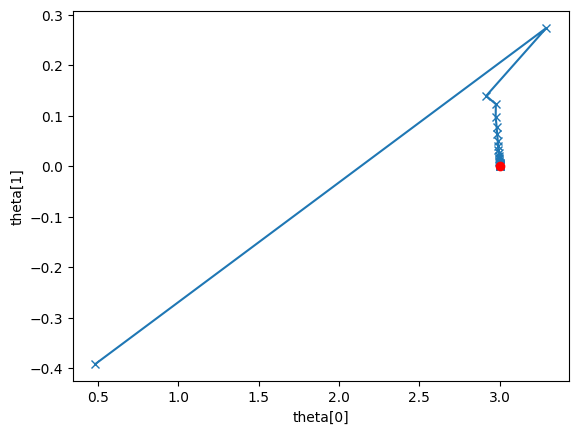

In [ ]:
# Now let us plot in 2D what happened to theta during SGD optimization. In red is the true relation.
thetas = torch.cat(thetatrace, dim=0).numpy()
plt.figure()
plt.plot(thetas[:,0], thetas[:, 1], 'x-')
plt.plot(3, 0, 'ro')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')

Ok, doing this manually gives you insight what happens down to the details. But usually we do not do the gradient updates manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us abstractions to easily manage this complexity:
* `nn.Linear()` (or generally  `Module`s) which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
* `module.zero_grad()` to clear the gradients,
* `optim.SGD` with which you can do `optimizer.step()` to do a step of SGD.

In [ ]:
torch.manual_seed(23801)
net = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100): # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[3.0000e+00, 1.0507e-07]], requires_grad=True)


Indeed this is very close to the optimal $\theta=[3,0]$.